# Demo CNN for Wildfire Growth Prediction

Below is starter code for a cnn solution to solve the wildfire growth challenge!

We provide infrastructure and helper functions to call and process the data.

It is up to your team to fill in necessary blanks and improve the pipeline.

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and set to:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU is available and set to: Tesla T4


#### Pip Install

In [2]:
!pip install rasterio matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/MAG_Wildfire_Hackathon/Wildfire_Hackathon_Complete'

/content/drive/.shortcut-targets-by-id/1MNSgACFZBntIhsetYbiUztFCcTtX8ZoD/MAG_Wildfire_Hackathon/Wildfire_Hackathon_Complete


In [5]:
!ls

'0.load data -- Aania edits.ipynb'   demo-MVP-Aaryaman.ipynb	    hotspots
'0. load data.ipynb'		     demo-MVP-bilaledits.ipynb	    output
'1. demo-MVP.ipynb'		     demo-MVP-bilalforecast.ipynb   test
 Aadi.ipynb			     demo-MVP-maanav1.ipynb	    train
 Aania_forecast.ipynb		     demo-MVP-maanav.ipynb	    wildfire-hackathon-kaggle.zip
 demo-MVP-Aania.ipynb		     fbp_lookup.csv


In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

# Paths for data and fires
data_path = "./"
train_path = data_path + "train/"
test_path = data_path + "test/"
tr_fnums = ["fire1209", "fire1298", "fire1386", "fire2034", "fire2210", "fire2211", "fire2212"]
te_fnums = ["fire2214"]

In [7]:
# Util variables
device = 'cuda'
target_shape = (528, 720)

# Util functions
def pad_to_fit(d, shape):
    h, w = d.shape
    pad_h = shape[0] - h
    pad_w = shape[1] - w
    if pad_h > 0 or pad_w > 0:
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        d = np.pad(d, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    return d

def normalize(d):
    m = np.mean(d)
    s = np.std(d)
    return (d - m)/s

def tif2np(tif):
    with rio.open(tif) as src:
        data = src.read(1)  # Read the first band
    return pad_to_fit(np.nan_to_num(data, nan=0.0), target_shape)

## Functions to load data

The load fire function loads and processes data for the denoted fire. The fire is then stacked into a numpy array.

The load day function loads in a day of data for a specified fire.

<ins>**Additional data should be loaded and specified into this function**.<ins>

In [ ]:
#import geopandas as gpd

#fire1209_shp = gpd.read_file('/content/drive/MyDrive/MAG_Wildfire_Hackathon/Wildfire_Hackathon_Complete/train/fire1209/fire/fire1209.shp')
# fire1209.ignition

In [ ]:
#fire1209_shp

In [8]:
def load_day(path, day):
    # weather relative humidity
    wrh = path+'/weather/noon_relative_humidity_day{}.tif'.format(day)
    wrh = normalize(tif2np(wrh))
    # weather wind speed
    wws = path+'/weather/noon_wind_speed_day{}.tif'.format(day)
    wws = normalize(tif2np(wws))
    # Add more data here
    ap24 = path+'/weather/24hr_accumulated_precipitation_day{}.tif'.format(day)
    ap24 = normalize(tif2np(ap24))

    mt24 = path+'/weather/24hr_max_temperature_day{}.tif'.format(day)
    mt24 = normalize(tif2np(mt24))

    nt = path+'/weather/noon_temperature_day{}.tif'.format(day)
    nt = normalize(tif2np(nt))

    nwd = path+'/weather/noon_wind_direction_day{}.tif'.format(day)
    nwd = normalize(tif2np(nwd))

    # fire_weather
    fwi = path+'/fire_weather/fire_weather_index_day{}.tif'.format(day)
    fwi = normalize(tif2np(fwi))
    # weather buildup index day
    wbi = path+'/fire_weather/build_up_index_day{}.tif'.format(day)
    wbi = normalize(tif2np(wbi))
    # drought codeday
    dcd = path+'/fire_weather/drought_code_day{}.tif'.format(day)
    dcd = normalize(tif2np(dcd))
    # moisture code
    dfc = path+'/fire_weather/duff_moisture_code_day{}.tif'.format(day)
    dfc = normalize(tif2np(dfc))
    # initial spread
    isi = path+'/fire_weather/initial_spread_index_day{}.tif'.format(day)
    isi = normalize(tif2np(isi))

    ffm = path+'/fire_weather/fine_fuel_moisture_code_day{}.tif'.format(day)
    ffm = normalize(tif2np(ffm))

#   return [wrh, wws, mt24, ap24, nt, nwd, fwi, wbi, dcd, dfc, isi, ffm]
    return [wrh, wws, mt24, nt, nwd, fwi, wbi, dcd, dfc, isi, ffm]

def load_fire(fire_num, split = "Train"):
    path = train_path + fire_num
    if split == "Test":
        path = test_path + fire_num

    ftif = path + "/fire/{}.tif".format(fire_num)
    if split == "Test":
        ftif = path + "/fire/{}_train.tif".format(fire_num)
    fdata = tif2np(ftif)

    minjd, maxjd = int(np.min(fdata[np.nonzero(fdata)])), int(np.max(fdata))
    lastjd = maxjd
    if split == "Test":
        maxjd += 21

    elev = normalize(tif2np(path+'/topography/dem.tif'))
    slope = normalize(tif2np(path+'/topography/slope.tif'))
    # review fuels to keep
    fuels = tif2np(path+'/fuels/fbp_fuels.tif')
    ignition = tif2np(path+'/fire/ignitions.tif')


    dataset = []
    gt = ignition
    cfire = ignition
    for d in range(minjd, maxjd):
        data = {}

        fuels[cfire != 0] = 0
        ft = [fuels]
        ft.extend([cfire, gt, slope, elev])
        ft.extend(load_day(path, d))
        ft = np.stack(ft)
        data['ft'] = ft

        if d < lastjd:
            gt = fdata == float(d)
            data['gt'] = gt

        cfire = np.logical_or(cfire ,gt)

        dataset.append(data)
    return dataset

## Create the datasets and dataloaders

<ins>Create/implement data augmentations/transformations here<ins>

## Define the network/model

In this example, we define a simple 2 layer cnn model.

<ins>**Modify the model as you see fit!**<ins>

In [9]:
class FireDataset(Dataset):
    def __init__(self, split="Train"):
        fnums = tr_fnums if split=="Train" else te_fnums
        self.dataset = []
        for fnum in fnums:
            self.dataset.extend(load_fire(fnum, split=split))
        print(len(self.dataset))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

trainset = FireDataset(split="Train")
trainset, valset = torch.utils.data.random_split(trainset, [0.9,0.1])
testset = FireDataset(split="Test")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

<ipython-input-7-5d052e1dc572>:22: RuntimeWarning: invalid value encountered in divide
  return (d - m)/s


245
30


In [10]:
import torch
import torch.nn as nn

class FuelEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super(FuelEmbeddings, self).__init__()

        unique_values = [0, 1, 2, 3, 4, 7, 13, 31, 101, 425, 635, 650, 665]
        self.unique_values = torch.tensor(unique_values).to(device)  # Unique values in the categorical feature
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings=len(unique_values), embedding_dim=embedding_dim)

    def forward(self, categorical_feature):
        # (B,H,W) -> (B,H,W,U) wher U is unique values count
        mask = categorical_feature.unsqueeze(-1) == self.unique_values
        matching_indices = torch.argmax(mask.int(), dim=-1)

        # Apply embedding and reshape
        # (B,H,W,U) -> (B,H,W,6) -> (B,6,H,W) in default setting
        embedded_fuel = self.embedding(matching_indices)
        embedded_reshaped_fuel = embedded_fuel.permute(0, 3, 1, 2)

        return embedded_reshaped_fuel

class CNN1(nn.Module):
    def __init__(self, embedding_dim=6, num_features=8):
        super(CNN1, self).__init__()

        self.fuelembedding = FuelEmbeddings(embedding_dim)

        # (266, 433)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=(embedding_dim+num_features-1), out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)
        )
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)  # Example dropout with probability 0.5


    def forward(self, x):
        categorical_feature = x[:, 0, :, :]  # Extract the categorical feature
        embedded_fuel = self.fuelembedding(categorical_feature)  # Transform the categorical feature

        # Replace the original categorical feature with the embedded feature
        x = torch.cat((embedded_fuel, x[:, 1:, :, :]), dim=1)

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.sigmoid(x)
        x = self.dropout(x)

        return out


## Define Loss function

<ins>**Create/define/specify your own loss function here!**<ins>

In [11]:
import torch
import torch.nn as nn

class IoULoss(nn.Module):
    def __init__(self, threshold=0.5):
        super(IoULoss, self).__init__()
        self.threshold = threshold

    def forward(self, outputs, labels):
        # threshold condition is not differentiable so just use softmaxed data
        # Flatten the tensors
        outputs = outputs.view(-1)
        labels = labels.view(-1)

        # Compute the intersection
        intersection = (outputs * labels).sum()

        # Compute the union
        union = outputs.sum() + labels.sum() - intersection
        iou = intersection / (union + 1e-6)  # Add a small epsilon for numerical stability
        loss = 1 - iou
        return loss

#### Metrics for evaluation

In [12]:
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

#### Train function

In [13]:
# Train
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    total_steps = 0
    for i, batch in enumerate(dataloader):
        ft = batch['ft'].to(device).float()
        gt = batch['gt'].to(device).float()

        optimizer.zero_grad()
        output = model(ft).squeeze()

        loss = criterion(output, gt)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_steps += 1
    return running_loss/total_steps

#### Eval function

In [14]:
def eval(model, dataloader):
    model.eval()
    acc = []
    iou = []
    f1 = []
    total_steps = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            ft = batch['ft'].to(device)
            gt = torch.flatten(batch['gt'])

            output = torch.flatten(model(ft)).squeeze().cpu()
            output = (output > 0.5)

            acc.append(accuracy_score(gt, output))
            iou.append(jaccard_score(gt, output))
            f1.append(f1_score(gt, output))
            total_steps += 1
    return sum(acc)/total_steps, sum(iou)/total_steps, sum(f1)/total_steps

#### Inference function

Saves the inference results to a submission file!

In [15]:
def inference(model, dataloader):
    model.eval()
    with torch.no_grad():
        cfire = torch.zeros(target_shape)
        for i, day in enumerate(dataloader):
            ft = day['ft'].to(device)

            # Create the submission file after 10 days
            if i > 9:
                cfire = torch.logical_or(output, cfire) # define the cumulative fire
                ft[0][1] = cfire # set the cumulative fire for the next input
                ft[0][2] = output # set the next step fire for the next input
            else:
                cfire = ft[0][1]

            output = model(ft)
            output = (output > 0.5)

    # Save the cumulative fire
    pred = cfire.cpu().squeeze().numpy()
    save_df = pd.DataFrame(pred)  # convert img data to df
    save_df.to_csv("./output/submission.csv", index_label='row')
    return pred

#### The training/eval/inference loop

<ins>**Define new optimizers here**<ins>

<ins>**Utilize a scheduler here**<ins>

<ins>**Change the learning rate here**<ins>

<ins>**Implement a better early stopping strategy here**<ins>

<ins>**Implement other tricks here (i.e. EMA)**<ins>


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim=6, num_features=8, hidden_dim=50, num_layers=2):
        super(LSTMModel, self).__init__()

        self.fuelembedding = FuelEmbeddings(embedding_dim)
        self.num_features = num_features

        # Assuming the input sequence length is 10 days
        self.lstm = nn.LSTM(input_size=(embedding_dim + num_features - 1),
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, (embedding_dim + num_features - 1) * 20)  # Predicting for 20 future days
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_len, num_channels, height, width = x.size()

        # Process each time step individually
        outputs = []
        for t in range(seq_len):
            categorical_feature = x[:, t, 0, :, :]  # Extract the categorical feature for time step t
            embedded_fuel = self.fuelembedding(categorical_feature)  # Transform the categorical feature

            # Replace the original categorical feature with the embedded feature
            features = torch.cat((embedded_fuel, x[:, t, 1:, :, :]), dim=1)
            features = features.view(batch_size, -1)  # Flatten spatial dimensions

            outputs.append(features)

        # Convert list of outputs to tensor (batch_size, seq_len, num_features)
        lstm_input = torch.stack(outputs, dim=1)

        lstm_out, _ = self.lstm(lstm_input)
        lstm_out = lstm_out[:, -1, :]  # Take the output from the last time step

        out = self.fc(lstm_out)
        out = self.sigmoid(out)
        out = out.view(batch_size, 20, self.num_features, height, width)  # Reshape to (batch_size, 20 days, num_features, height, width)

        return out

# Example usage:
# Assuming FuelEmbeddings is defined elsewhere
# model = LSTMModel(embedding_dim=6, num_features=8, hidden_dim=50, num_layers=2)
# input_data = torch.randn(32, 10, 8, 266, 433)  # Example input: batch_size=32, seq_len=10, num_features=8, height=266, width=433
# output = model(input_data)


In [ ]:
# Train
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0
    total_steps = 0
    for i, batch in enumerate(dataloader):
        ft = batch['ft'].to(device).float()
        gt = batch['gt'].to(device).float()

        optimizer.zero_grad()
        output = model(ft).squeeze()

        loss = criterion(output, gt)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_steps += 1
    return running_loss/total_steps

In [17]:
# Create dummy data
batch_size = 32
seq_len = 10  # First 10 days
num_features = 8
height = 266
width = 433

input_data = torch.randn(batch_size, seq_len, num_features, height, width)

# Instantiate the model
model = LSTMModel(embedding_dim=6, num_features=8, hidden_dim=50, num_layers=2)


In [18]:
criterion = IoULoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## early stopping
best_valid_loss = float('inf')
early_stopping_patience = 5
epochs_without_improvement = 0
l1_lambda=0.01

epochs = 20
best_miou = 0
for e in range(epochs):
    loss = train(model, trainloader, optimizer, criterion)
    aa, miou, mf1 = eval(model,valloader)

    if loss < best_valid_loss:
        lowest_loss = loss
    elif epochs_without_improvement < early_stopping_patience:
      epochs_without_improvement +=1
    else:
      print('Early Stopping...')
      cfire = inference(model, testloader)
      e = str(e)+"*"
      break

    # L1 regularization
    l1_regularization = 0
    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)
    loss += l1_lambda * l1_regularization

    # Update optimizer to include L1 regularization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    if miou > best_miou:
        best_miou = miou
        cfire = inference(model, testloader)
        e = str(e)+"*"
    print(e, " avg iou loss:{:.3f} avg acc: {:.3f} avg f1: {:.3f} avg iou jaccard score: {:.3f}".format(loss, aa, mf1, miou))



ValueError: not enough values to unpack (expected 5, got 4)

## Other Ideas to implement!

<ins>**Ensemble learning - voting**<ins>

<ins>**Implement hot spot data pipeline**<ins>

<ins>**Make better use of temporal data**<ins>

<ins>**Get creative!**<ins>

## Hotspot Data

<Axes: >

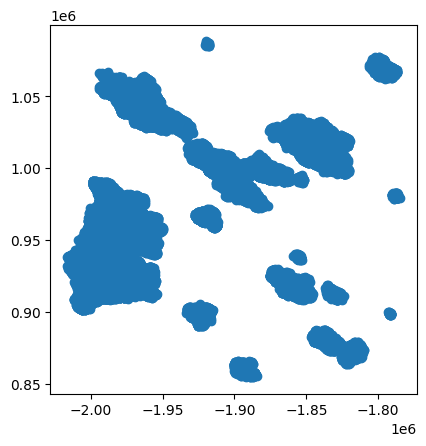

In [19]:
import geopandas as gpd

hotspots_path = "hotspots/m3_hotspots2.shp"

hotspots=gpd.read_file(hotspots_path)
hotspots.plot()

<Axes: >

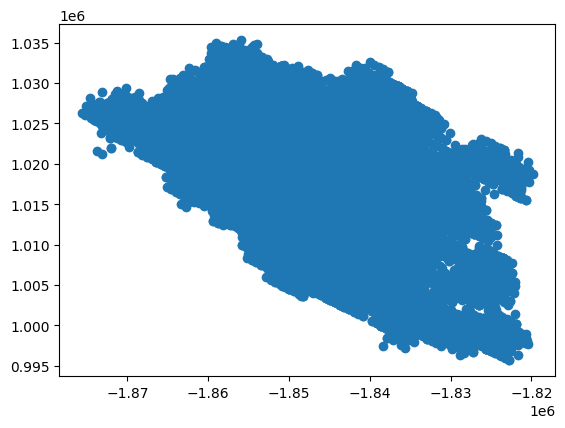

In [46]:
hotspots[hotspots["NFIREID"]==1209].plot()

In [50]:
hotspots

,FID_1,lat,lon,rep_date,uid,source,sensor,satellite,agency,temp,...,sfl,FID_2,UID_1,HCOUNT,AREA,FIRSTDATE,LASTDATE,NFIREID,Distance,geometry
1,3,54.1535,-124.504,2018/08/18 10:41:31.000,5469556,UMD,VIIRS,S-NPP,BC,20.267,...,0.0,0,10781819.0,33852.0,114724.662803,2018-06-21 10:20:00,2018-10-26 22:05:00,1209,0.0,POINT (-1828034.400 999997.271)
2,4,54.1400,-124.668,2018/08/18 10:41:31.000,5469573,UMD,VIIRS,S-NPP,BC,19.183,...,0.0,0,10781819.0,33852.0,114724.662803,2018-06-21 10:20:00,2018-10-26 22:05:00,1209,0.0,POINT (-1838114.641 1003403.141)
3,6,54.1461,-124.492,2018/08/18 20:30:25.000,5471091,UMD,VIIRS,S-NPP,BC,20.256,...,0.0,0,10781819.0,33852.0,114724.662803,2018-06-21 10:20:00,2018-10-26 22:05:00,1209,0.0,POINT (-1827707.126 998928.021)
4,7,54.1878,-124.505,2018/08/18 20:22:00.000,5474079,USFS,IBAND,S-NPP,BC,20.217,...,0.0,0,10781819.0,33852.0,114724.662803,2018-06-21 10:20:00,2018-10-26 22:05:00,1209,0.0,POINT (-1826412.313 1003383.136)
5,8,54.1534,-124.619,2018/08/18 22:04:00.000,5474202,USFS,IBAND,S-NPP,BC,20.007,...,0.0,0,10781819.0,33852.0,114724.662803,2018-06-21 10:20:00,2018-10-26 22:05:00,1209,0.0,POINT (-1834642.795 1003299.909)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195613,195502,52.9007,-126.332,2018/08/07 20:35:00.000,5257534,USFS,IBAND,S-NPP,BC,24.977,...,0.0,21,10781833.0,61696.0,96359.465938,2018-08-01 09:17:00,2018-09-07 21:20:00,2211,0.0,POINT (-1997231.525 933028.481)
195614,195503,52.9001,-126.316,2018/08/07 20:35:00.000,5257535,USFS,IBAND,S-NPP,BC,25.268,...,0.0,21,10781833.0,61696.0,96359.465938,2018-08-01 09:17:00,2018-09-07 21:20:00,2211,0.0,POINT (-1996326.766 932467.914)
195615,195504,52.9000,-126.338,2018/08/07 10:40:00.000,5257536,USFS,IBAND,S-NPP,BC,24.909,...,0.0,21,10781833.0,61696.0,96359.465938,2018-08-01 09:17:00,2018-09-07 21:20:00,2211,0.0,POINT (-1997616.617 933152.947)
195616,195505,52.8955,-126.337,2018/08/07 20:35:00.000,5257537,USFS,IBAND,S-NPP,BC,24.906,...,0.0,21,10781833.0,61696.0,96359.465938,2018-08-01 09:17:00,2018-09-07 21:20:00,2211,0.0,POINT (-1997791.337 932687.173)


In [26]:
hotspots[hotspots["NFIREID"] == 1209].rep_date.value_counts()

rep_date
2018/08/14 10:09:00.000    837
2018/08/15 09:54:00.000    749
2018/08/18 10:34:00.000    740
2018/08/16 21:06:00.000    669
2018/08/11 11:10:00.000    561
                          ... 
2018/08/30 20:06:00.000      1
2018/07/28 10:34:54.000      1
2018/08/30 20:06:47.000      1
2018/08/05 19:25:00.000      1
2018/08/05 19:33:00.000      1
Name: count, Length: 530, dtype: int64

In [49]:
from IPython.display import display

import folium
from shapely.geometry import Point


In [55]:
# Create a Folium map centered at an average location
m = folium.Map(location=[hotspots[hotspots["NFIREID"]==2214].geometry.y.mean(), hotspots.geometry.x.mean()], zoom_start=6)

# Function to add points to the map
def add_point_to_map(row):
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Fire: {row['NFIREID']}\nTemp: {row['temp']}"
    ).add_to(m)

# Apply the function to each row in the GeoDataFrame
hotspots.apply(add_point_to_map, axis=1)

# Save the map to an HTML file
m.save('map.html')

In [30]:
fires = hotspots.NFIREID.unique()

In [ ]:

for category in categories:
    # Filter the GeoDataFrame by the current category
    filtered_gdf = gdf[gdf['category'] == category]

    # Define the filename using the category name
    filename = f'filtered_{category}.shp'  # Save as shapefile

    # Save the filtered GeoDataFrame to a shapefile
    filtered_gdf.to_file(filename)

    print(f'Saved {filename}')

In [35]:
for code in fires:
  hot_code = hotspots[hotspots["NFIREID"]==code]
  filename = f"{code}.shp"
  hot_code.to_file(filename)

## Forecasting Model

In [ ]:
class FireDatasetForecast(Dataset):
    def __init__(self, split="Train"):
        fnums = tr_fnums if split=="Train" else te_fnums
        self.dataset = []
        for fnum in fnums:
            self.dataset.extend(load_fire(fnum, split=split))
        print(len(self.dataset))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

trainset = FireDataset(split="Train")
trainset, valset = torch.utils.data.random_split(trainset, [0.9,0.1])
testset = FireDataset(split="Test")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class FuelEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super(FuelEmbeddings, self).__init__()

        unique_values = [0, 1, 2, 3, 4, 7, 13, 31, 101, 425, 635, 650, 665]
        self.unique_values = torch.tensor(unique_values).to(device)  # Unique values in the categorical feature
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings=len(unique_values), embedding_dim=embedding_dim)

    def forward(self, categorical_feature):
        # (B,H,W) -> (B,H,W,U) wher U is unique values count
        mask = categorical_feature.unsqueeze(-1) == self.unique_values
        matching_indices = torch.argmax(mask.int(), dim=-1)

        # Apply embedding and reshape
        # (B,H,W,U) -> (B,H,W,6) -> (B,6,H,W) in default setting
        embedded_fuel = self.embedding(matching_indices)
        embedded_reshaped_fuel = embedded_fuel.permute(0, 3, 1, 2)

        return embedded_reshaped_fuel

class CNN1(nn.Module):
    def __init__(self, embedding_dim=6, num_features=8):
        super(CNN1, self).__init__()

        self.fuelembedding = FuelEmbeddings(embedding_dim)

        # (266, 433)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=(embedding_dim+num_features-1), out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

        self.dropout = nn.Dropout(p=0.5)  # Example dropout with probability 0.5


    def forward(self, x):
        categorical_feature = x[:, 0, :, :]  # Extract the categorical feature
        embedded_fuel = self.fuelembedding(categorical_feature)  # Transform the categorical feature

        # Replace the original categorical feature with the embedded feature
        x = torch.cat((embedded_fuel, x[:, 1:, :, :]), dim=1)

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.sigmoid(x)

        x = self.dropout(x)

        return out


# Graphs and Analysis

In [36]:
!pip install rasterio matplotlib

In [37]:
import numpy as np
import pandas as pd
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [44]:
path = "./"
fire_num = 2214
fire = path+f'/test/fire{fire_num}'

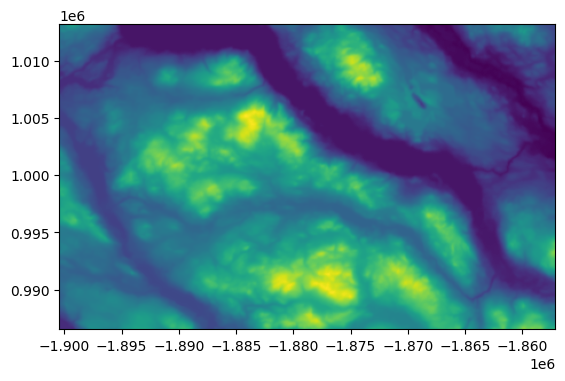

(266, 433)


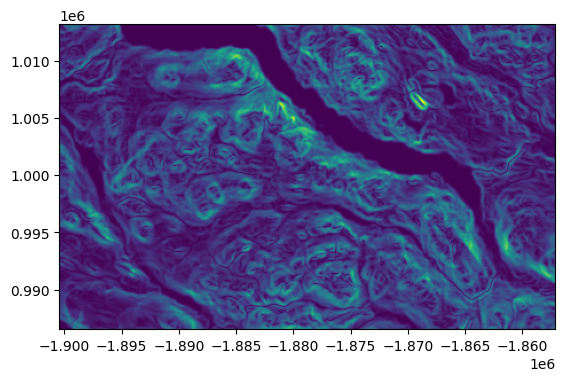

(266, 433)


In [45]:
tiff_file = fire+"/topography/dem.tif"
img = rasterio.open(tiff_file)
show(img)

print(img.shape)

tiff_file = fire+"/topography/slope.tif"
img = rasterio.open(tiff_file)
show(img)

print(img.shape)